# Importation des données

In [38]:
import pickle

MAIN_PATH = './data/prepared_data/'
USEFULL_PATH = MAIN_PATH + 'useful/'

def load_pickle(path: str):
    """
    Load a pickle file.

    Parameters
    ----------
    path : str
        Path to the pickle file.

    Returns
    -------
    object
        The object stored in the pickle file.
    """
    with open(path, 'rb') as f:
        return pickle.load(f)

# Load data
X_useful_train = load_pickle(USEFULL_PATH + 'X_useful_train.pkl')
X_useful_test = load_pickle(USEFULL_PATH + 'X_useful_test.pkl')
Y_useful_train = load_pickle(USEFULL_PATH + 'Y_useful_train.pkl')
Y_useful_test = load_pickle(USEFULL_PATH + 'Y_useful_test.pkl')

# Entrainement des modèles

Pour pouvoir déterminer les facteurs indicants le départ potentiel d'un employé, il a été décidé de tester plusieurs modèles de classification. Il en existe plusieurs mais nous avons décidé de nous attarder sur certains modèles qui nous semblent les plus pertinents. Nous avons donc testé les modèles suivants:

- SGDClassifier : Cette méthode est basée sur la descente de gradient stochastique. Elle est particulièrement adaptée pour les problèmes de grande taille et pour les données qui ne tiennent pas en mémoire. Elle est également très efficace pour les données textuelles.
- RandomForestClassifier : Les forêts aléatoires sont un ensemble d'arbres de décision. Chaque arbre est entraîné sur un échantillon aléatoire de données. La prédiction est faite par vote majoritaire des arbres. Les forêts aléatoires sont très efficaces pour les problèmes de classification et de régression.
- Régression logistique : La régression logistique est un modèle linéaire pour la classification. Elle est particulièrement adaptée pour les problèmes de classification binaire.
- Perceptron : Le perceptron est un algorithme d'apprentissage supervisé. Il est utilisé pour la classification binaire et pour la classification multi-classe. Il est basé sur la descente de gradient stochastique.

Le but de cette étape est de déterminer le modèle qui nous permettra de prédire le départ d'un employé avec le plus de précision possible. Pour cela, nous allons tester les différents modèles sur les données d'entrainement et nous allons comparer les résultats obtenus via divers métriques comme la courbe ROC, l'Aire sous la courbe, les scores de précision et de rappel ou encore les moyennes harmoniques.

## SGD Classifier

Commençons par tester le modèle SGDClassifier. Pour cela, nous allons utiliser la fonction SGDClassifier() de la librairie sklearn.linear_model. Nous allons ensuite entrainer le modèle sur les données d'entrainement et tester le modèle sur les données de test. Nous allons ensuite calculer les métriques de précision et de rappel et afficher la courbe ROC.

In [39]:
from sklearn.linear_model import SGDClassifier

# Instantiate classifier
sgd_clf = SGDClassifier(random_state=42)

# Fit classifier
sgd_clf.fit(X_useful_train, Y_useful_train)

SGDClassifier(random_state=42)

Pour déterminer la performance de cette algorithme, nous allons passer par plusieurs métriques :

* Une validation croisée pour déterminer la précision du modèle
* Des scores de précision et de rappel ainsi qu'une moyenne harmonique pour déterminer le pourcentage concernant la répartition des données (Un graphique sera très utile pour appuyer le choix entre précision et rappel)
* Une courbe ROC ainsi que son AUC qui permet de déterminer la précision du modèle

À noter que ces métriques seront utilisés sur les autres algorithmes à tester pour comparer les performances de ces derniers entre eux

In [40]:
from sklearn.model_selection import cross_val_score

# Cross-validate classifier
cross_val_score(sgd_clf, X_useful_train, Y_useful_train, cv=3, scoring="accuracy")

array([0.82823129, 0.84183673, 0.84863946])

In [41]:
from sklearn.model_selection import cross_val_predict

# Cross-validate classifier
y_train_pred = cross_val_predict(sgd_clf, X_useful_train, Y_useful_train, cv=3)

In [42]:
from sklearn.metrics import precision_score, recall_score

# Calculate precision
precision_score(Y_useful_train, y_train_pred)

0.5039787798408488

In [43]:
# Calculate recall
recall_score(Y_useful_train, y_train_pred)

0.3339191564147627

In [44]:
from sklearn.metrics import f1_score

# Calculate F1 score
f1_score(Y_useful_train, y_train_pred)

0.40169133192389006

In [45]:
from sklearn.metrics import precision_recall_curve

# Show the precision/recall curve
y_scores = cross_val_predict(sgd_clf, X_useful_train, Y_useful_train, 
                             cv=3, method="decision_function")

precision, recall, thresholds = precision_recall_curve(Y_useful_train, y_scores)

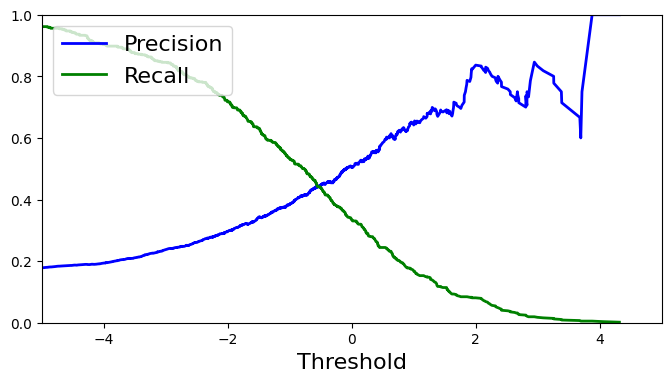

In [46]:
from matplotlib import pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b-", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precision, recall, thresholds)
plt.xlim([-5, 5])
plt.show()

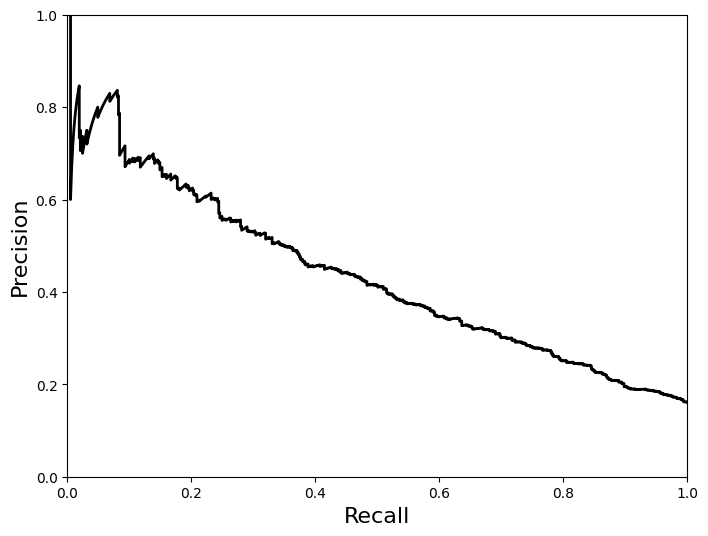

In [47]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "k-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precision, recall)
plt.show()

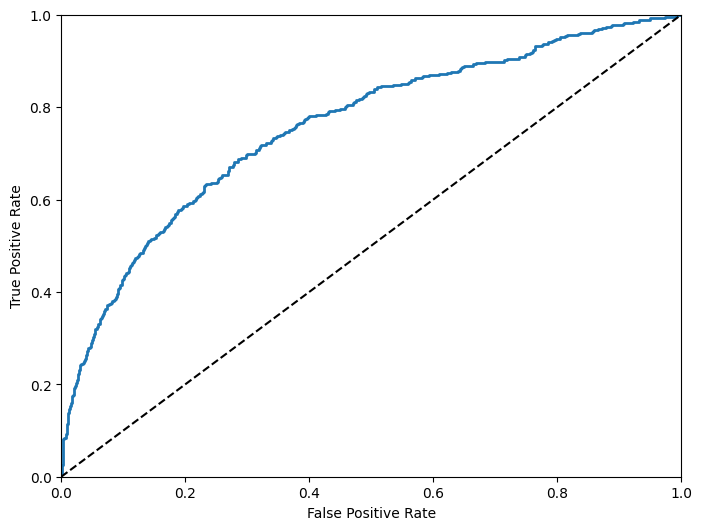

In [48]:
from sklearn.metrics import roc_curve

# Show the ROC curve
fpr, tpr, thresholds = roc_curve(Y_useful_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [49]:
from sklearn.metrics import roc_auc_score

# Calculate AUC
roc_auc_score(Y_useful_train, y_scores)

0.757698505230535

Dans le cas du SGDClassifier, on obtient des résultats satisfaisant mais il est sûrement possible de faire mieux avec un autre algorithme étant donné la nature de notre jeu de données.

## Random Forest

Pour comparer les résultats obtenus avec le modèle SGDClassifier, nous allons tester le modèle RandomForestClassifier. Pour cela, nous allons utiliser la fonction RandomForestClassifier() de la librairie sklearn.ensemble. Nous allons ensuite entrainer le modèle sur les données d'entrainement et tester le modèle sur les données de test. Nous allons ensuite calculer les métriques de précision et de rappel et afficher la courbe ROC.

In [50]:
from sklearn.ensemble import RandomForestClassifier
from time import time

start = time()

# Instantiate classifier
forest_clf = RandomForestClassifier(random_state=42, n_estimators=500, max_depth=50)

# Fit classifier
forest_clf.fit(X_useful_train, Y_useful_train)

y_probas_forest = cross_val_predict(forest_clf, X_useful_train, Y_useful_train, cv=3, 
                                    method="predict_proba")

TIME_FOREST = ["Random Forest", time() - start]

In [51]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(Y_useful_train, y_scores_forest)

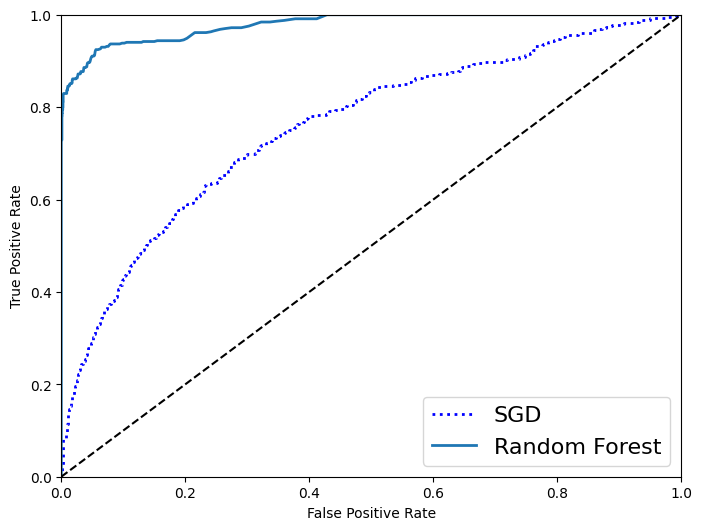

In [52]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [53]:
# Calculate AUC
roc_auc_score(Y_useful_train, y_scores_forest)

0.9788091022533499

In [54]:
# Calculate precision
precision_score(Y_useful_train, y_train_pred)

0.5039787798408488

In [55]:
# Calculate recall
recall_score(Y_useful_train, y_train_pred)

0.3339191564147627

In [56]:
# Calculate F1 score
f1_score(Y_useful_train, y_train_pred)

0.40169133192389006

In [57]:
# Show the precision/recall curve
y_scores_forest = forest_clf.predict_proba(X_useful_test)[:, 1]

precision_forest, recall_forest, thresholds_forest = precision_recall_curve(Y_useful_test, y_scores_forest)

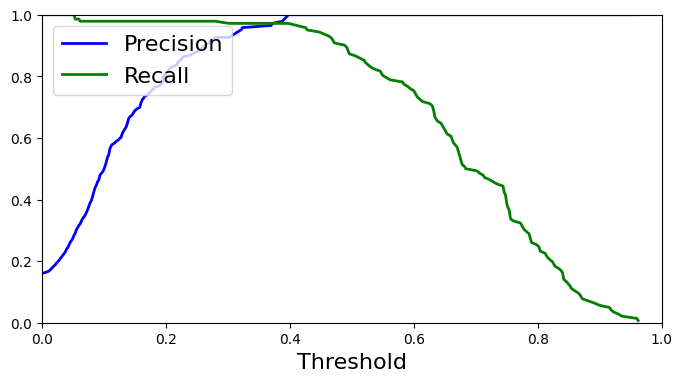

In [58]:
# Show the precision/recall curve
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precision_forest, recall_forest, thresholds_forest)
plt.xlim([0.0, 1.0])
plt.show()

Au vue des résultats obtenus largement supérieur à ceux du modèle SGDClassifier, nous pouvons déjà envisager d'utiliser le modèle RandomForestClassifier pour prédire le départ d'un employé. Nous allons tout de même tester les autres modèles pour voir si nous pouvons obtenir de meilleurs résultats.

## Régression Logistique

Dans le cas de la régression logistique, nous allons utiliser la fonction LogisticRegression() de la librairie sklearn.linear_model. Nous allons ensuite entrainer le modèle sur les données d'entrainement et tester le modèle sur les données de test. Nous allons ensuite calculer les métriques de précision et de rappel et afficher la courbe ROC.

In [59]:
from sklearn.linear_model import LogisticRegression

start = time()

# Instantiate classifier
log_clf = LogisticRegression(random_state=42)

# Fit classifier
log_clf.fit(X_useful_train, Y_useful_train)

TIME_LOG = ["Logistic Regression", time() - start]

/home/louis/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [60]:
# Cross-validate
y_probas_log = cross_val_predict(log_clf, X_useful_train, Y_useful_train, cv=3, 
                                 method="predict_proba")

y_scores_log = y_probas_log[:, 1]
fpr_log, tpr_log, thresholds_log = roc_curve(Y_useful_train, y_scores_log)

/home/louis/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/louis/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

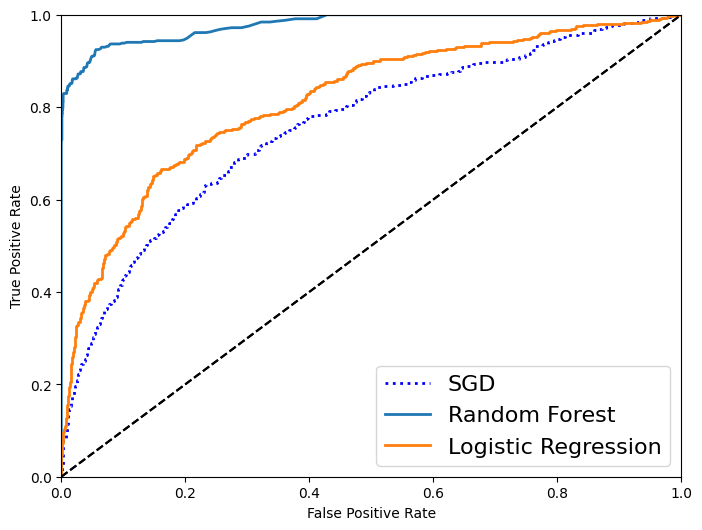

In [61]:
# Show the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plot_roc_curve(fpr_log, tpr_log, "Logistic Regression")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [62]:
# Calculate AUC
roc_auc_score(Y_useful_train, y_scores_log)

0.8146550008879407

In [63]:
# Calculate precision
precision_score(Y_useful_train, y_train_pred)

0.5039787798408488

In [64]:
# Calculate recall
recall_score(Y_useful_train, y_train_pred)

0.3339191564147627

In [65]:
# Calculate F1 score
f1_score(Y_useful_train, y_train_pred)

0.40169133192389006

In [66]:
# Show the precision/recall curve
y_scores_log = cross_val_predict(log_clf, X_useful_train, Y_useful_train, cv=3, 
                             method="decision_function")

precision_log, recall_log, thresholds_log = precision_recall_curve(Y_useful_train, y_scores_log)

/home/louis/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/louis/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

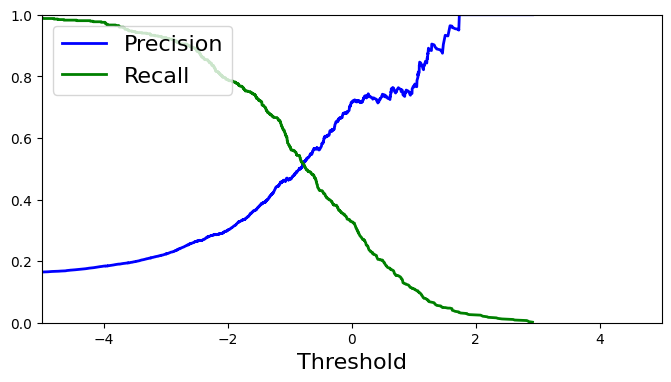

In [67]:
# Show the precision/recall curve
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precision_log, recall_log, thresholds_log)
plt.xlim([-5, 5])
plt.show()

Nous remarquons des résultats plus élevés que ceux obtenus avec le modèle SGDClassifier mais inférieurs à ceux obtenus avec le modèle RandomForestClassifier. 

## Perceptron

Pour finir, nous allons tester le modèle Perceptron. Pour cela, nous allons utiliser la fonction Perceptron() de la librairie sklearn.linear_model. Nous allons ensuite entrainer le modèle sur les données d'entrainement et tester le modèle sur les données de test. Nous allons ensuite calculer les métriques de précision et de rappel et afficher la courbe ROC.

In [68]:
from sklearn.linear_model import Perceptron

start = time()

# Instantiate classifier
per_clf = Perceptron(random_state=42, max_iter=1000)

# Fit classifier
per_clf.fit(X_useful_train, Y_useful_train)

TIME_PER = ["Perceptron", time() - start]

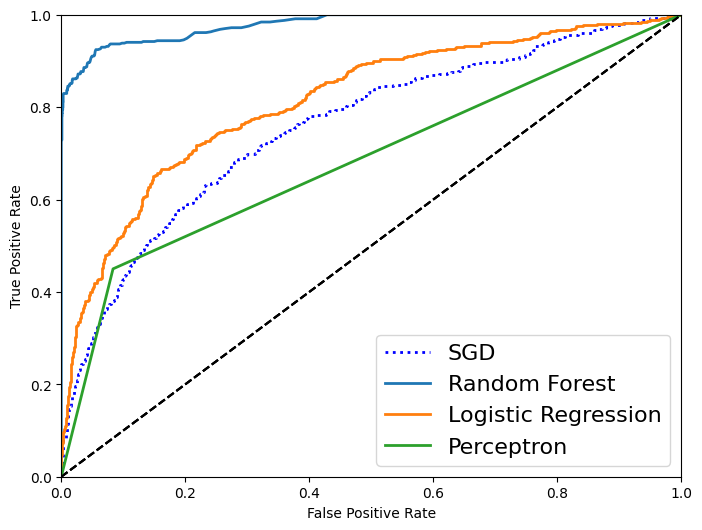

In [69]:
# Show the ROC curve
fpr_per, tpr_per, thresholds_per = roc_curve(Y_useful_train, per_clf.predict(X_useful_train))

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plot_roc_curve(fpr_log, tpr_log, "Logistic Regression")
plot_roc_curve(fpr_per, tpr_per, "Perceptron")
plt.legend(loc="lower right", fontsize=16)
plt.show()

# Amélioration Continue

Étant donnée les résultats obtenues précédents, il a été décidé que l'algorithme choisi pour traiter nos données seraient le RandomForest Classifier. Cependant, les tests effectués ne sont pas suffisants pour déterminer si le modèle est optimal, étant donné la prise en compte de paramètres par défaut pour tester l'efficatité des divers algorithmes en fonction d'un même jeu de donnée. Il est donc nécessaire de continuer à améliorer le modèle. Dans notre cas, il y a plusieurs stratégies qui peuvent être mises en place pour améliorer continuellement la performance de notre algorithme : 

1. Collecter et ajouter de nouvelles données : L'ajout de nouvelles données peut aider à améliorer la performance de l'algorithme en fournissant de nouvelles informations qui n'étaient pas disponibles dans les données précédentes. Il est important de s'assurer que les nouvelles données sont cohérentes avec les données précédentes et qu'elles couvrent les mêmes variables pour éviter tout biais dans l'analyse.

2. Optimiser les hyperparamètres : Les hyperparamètres tels que le nombre d'arbres, la profondeur de chaque arbre, la fraction d'échantillons à utiliser pour l'apprentissage, etc. peuvent être optimisés pour améliorer la performance de l'algorithme. Il est important d'essayer différentes combinaisons d'hyperparamètres et d'utiliser une validation croisée pour évaluer leur performance.

3. Utiliser des techniques de prétraitement des données : Les techniques de prétraitement des données telles que la normalisation, la standardisation, la sélection de variables, etc. peuvent aider à améliorer la performance de l'algorithme. Il est important d'expérimenter différentes techniques pour voir lesquelles fonctionnent le mieux pour les données spécifiques.

4. Effectuer une analyse post-mortem : L'analyse post-mortem est une technique qui consiste à analyser les erreurs de prédiction pour identifier les erreurs les plus fréquentes et les raisons pour lesquelles elles se produisent. Cette analyse peut aider à identifier les faiblesses de l'algorithme et à prendre des mesures pour les corriger.

5. Utiliser d'autres algorithmes : L'algorithme Random Forest est un bon choix pour la prédiction de la cause de départ des employés, mais il existe d'autres algorithmes tels que la régression logistique, les machines à vecteurs de support (SVM) ou les réseaux de neurones qui peuvent être utilisés pour améliorer la performance de la prédiction.


Les éléments qui peuvent être implémentés dans notre cas ou même retravaillé sont les suivants :

* Optimisation des hyperparamètres : Nous avons utilisé des hyperparamètres par défaut pour pouvoir comparer nos algorithmes, mais nous devons essayer d'autres combinaisons d'hyperparamètres pour voir si nous pouvons améliorer la performance de l'algorithme. Nous pouvons également utiliser une validation croisée pour évaluer la performance de chaque combinaison d'hyperparamètres.

In [70]:
# Importer la classe GridSearchCV pour la validation croisée et la recherche des meilleurs hyperparamètres
from sklearn.model_selection import GridSearchCV

# Définir les valeurs possibles pour chaque hyperparamètre
param_grid = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'max_depth': [5, 10, 20, 50, 100],
}

# Créer un objet GridSearchCV avec la classe Random Forest et les hyperparamètres définis
grid_search = GridSearchCV(estimator=forest_clf, param_grid=param_grid, cv=5)

# Exécuter la recherche des meilleurs hyperparamètres avec les données existantes
grid_search.fit(X_useful_train, Y_useful_train)

# Afficher les meilleurs hyperparamètres
grid_search.best_params_

{'max_depth': 50, 'n_estimators': 500}

* Analyse post-mortem : Nous pouvons analyser les erreurs de prédiction pour identifier les erreurs les plus fréquentes et les raisons pour lesquelles elles se produisent. Cette analyse peut nous aider à identifier les faiblesses de l'algorithme et à prendre des mesures pour les corriger.

* Changer les techniques de prétraitement des données : Nous pouvons essayer d'autres techniques de prétraitement des données pour voir si nous pouvons améliorer la performance de l'algorithme.

# Étude des résultats


Le ``RandomForestClassifier`` est le modèle qui a les meilleurs performances sur les données de test. Il est donc choisi pour la suite de l'étude.

On cherche à présent à savoir sur quel critère le modèle se base pour prédire si un employé va partir ou non l'année suivante.

In [71]:
import time
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd


def plot_feature_importances(X: pd.DataFrame, y: pd.DataFrame, title: str):
    """
    Plot the feature importances.

    Parameters
    ----------
    X : pandas.DataFrame
        The data to plot the feature importances.

    y : pandas.DataFrame
        The target to plot the feature importances.

    title : str
        The title of the plot.

    Returns
    -------
    None
    """
    feature_names = X.columns
    forest = RandomForestClassifier(random_state=0)
    forest.fit(X, y)

    start_time = time.time()
    importances = forest.feature_importances_
    std = np.std(
        [tree.feature_importances_ for tree in forest.estimators_], axis=0)
    elapsed_time = time.time() - start_time

    print(
        f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
    forest_importances = pd.Series(importances, index=feature_names)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title(title)
    ax.set_ylabel("Mean decrease in impurity")
    fig.set_size_inches(10, 10)
    # Draw line at 0.01 threshold
    ax.axhline(y=0.05, linestyle='--', color='r')
    fig.tight_layout()


Le graphique ci-dessous montre les importances des variables pour le modèle de forêt aléatoire. Les variables les plus importantes (>0.05, au dessus de la ligne rouge) sont les suivantes :
* **AvgTime** : temps de travail moyen par jour
* **YearsAtCompanyPerAge** : nombre d'années passées dans l'entreprise par âge
* **YearsWorkedPerAge** : nombre d'années travaillées par âge

Elapsed time to compute the importances: 0.005 seconds


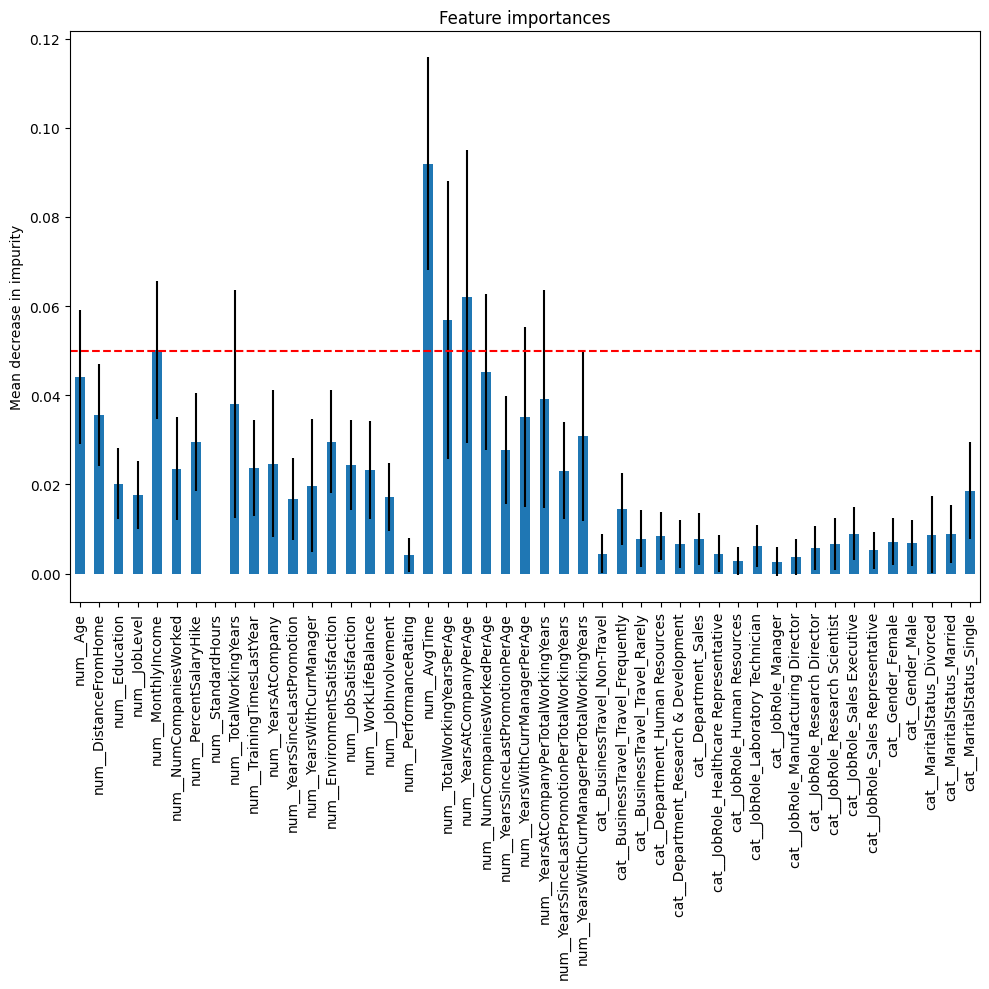

In [72]:
import numpy as np
from sklearn.inspection import PartialDependenceDisplay

# Analyser l'importance des variables
importances = forest_clf.feature_importances_
indices = np.argsort(importances)[::-1]
plot_feature_importances(X_useful_train, Y_useful_train, "Feature importances")

Afin de comprendre leur impact sur l'attrition, on visualise les effets de variables individuelles sur les prédictions à l'aide de graphiques de dépendance partielle (PDP). Le ce type de graphique, la courbe représente la prédiction moyenne de l'attrition pour une valeur donnée de la variable. Plus la courbe est élevée, plus l'attrition est élevée (vers le *Yes*). Si la ligne est plate, cela signifie que la variable n'a pas d'impact sur la prédiction.

Ici on remarque que plus le temps de travail moyen par jour est élevé, plus l'attrition est élevée. Cela peut s'expliquer par le fait que les employés qui travaillent plus de 8h par jour sont plus susceptibles de partir car ils sont plus fatigués et moins productifs.

De plus, les employés qui ont passé moins d'années dans l'entreprise, moins d'années travaillées et plus jeunes sont plus susceptibles de partir. Cela peut s'expliquer par le fait que les employés qui ont moins d'expérience sont plus enclins à changer d'emploi pour trouver un poste plus intéressant.

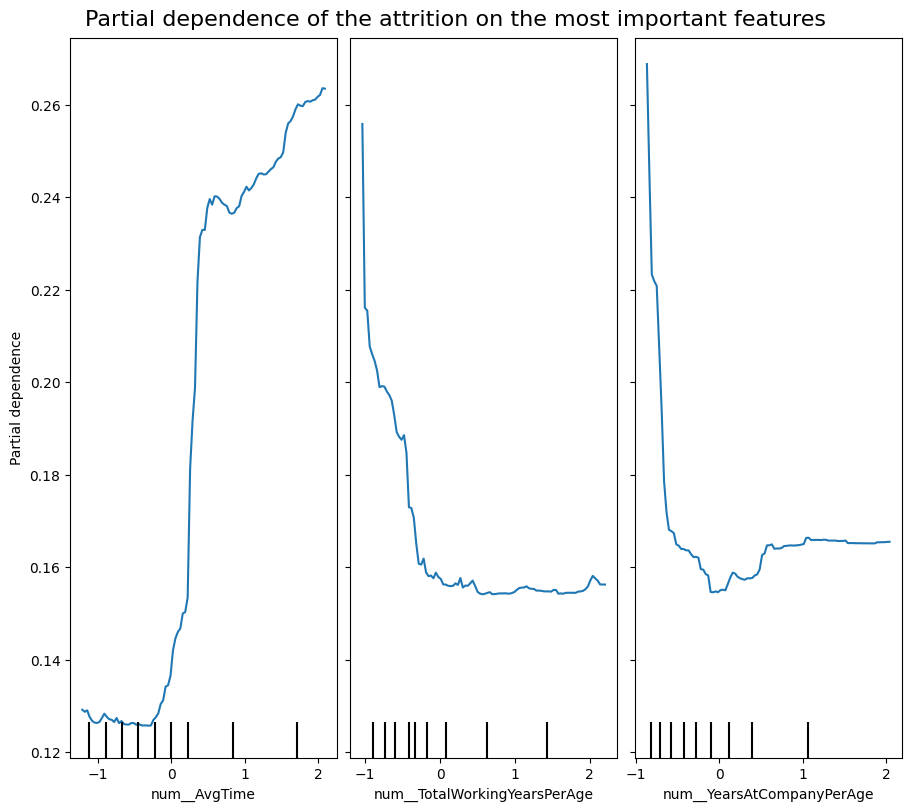

In [73]:
# Identifier les variables significatives
significant_features = X_useful_train.columns[importances > 0.05]

# Examiner les interactions entre les variables
# plot_partial_dependence(forest_clf, X_useful_train, significant_features)
_, ax = plt.subplots(figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    forest_clf,
    X_useful_train,
    significant_features,
    ax=ax
)
_ = display.figure_.suptitle(
    "Partial dependence of the attrition on the most important features",
    fontsize=16,
)

# Interpréter les résultats
predictions = forest_clf.predict(X_useful_test)


Les métrique ci-dessous montrent que le modèle est performant sur les données de test. Il a une précision de 0.97 et un rappel de 1. Cela signifie que le modèle est capable de prédire correctement 97% des cas de départ des employés et qu'il détecte 100% des cas de départ des employés.

In [74]:
from sklearn.metrics import classification_report
print(classification_report(Y_useful_test, predictions))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       740
           1       1.00      0.87      0.93       142

    accuracy                           0.98       882
   macro avg       0.99      0.93      0.96       882
weighted avg       0.98      0.98      0.98       882



## Etude comparative de temps de calcul

In [75]:
def compare_time(*args):
    print("Time elapsed:")
    for arg in args:
        print(f"- {arg[0]}: {arg[1]:.3f} seconds")

compare_time(TIME_FOREST, TIME_PER, TIME_LOG)

Time elapsed:
- Random Forest: 5.506 seconds
- Perceptron: 0.005 seconds
- Logistic Regression: 0.081 seconds
